# Overview
This notebook is an adaptation of one provided by the GOATOOLS authors in their GitHub repository (https://github.com/tanghaibao/goatools/blob/main/notebooks/Enrichment_analyses_human_phenotype_ontology.ipynb), adapted for the purposes of this study.

# Performing GO enrichment analysis

In [6]:
import pandas as pd
import os, glob, tqdm

In [7]:
secretome_n_transmembranome_table = pd.read_csv('../results/secretome_and_transmembranome_predictions/secretome_and_transmembranome_predictions.tsv', sep = '\t' )
inparalog_groups = pd.read_csv('../results/misc/inparalogs_group_composition_final.tsv', sep = '\t')

In [8]:
original2new = pd.read_csv('../results/misc/gene_code_correspondance.tsv', sep = '\t')

In [9]:
new2original_dict = {row['Original Name']: row['New Name'] for index,row in original2new.iterrows()}

In [10]:
from goatools.obo_parser import GODag

godag = GODag('../data/go-basic.obo')

../data/go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms


In [11]:
goslim = GODag('../data/goslim_generic.obo')

../data/goslim_generic.obo: fmt(1.2) rel(go/2024-01-17/subsets/goslim_generic.owl) 206 Terms


Only genes that present detected homologs are considered in the analysis, so listing them.

In [12]:
import glob
from Bio import SeqIO
from concurrent.futures import ThreadPoolExecutor

# Function to process each FASTA file
def process_fasta(file_path):
    ids = []
    records = list(SeqIO.parse(file_path, "fasta"))
    if len(records) > 1:
        ids = [record.id for record in records]
    return ids

# Path to the fasta files
fasta_files = glob.glob('../results/homolog_groups/*')

# Use ThreadPoolExecutor to process files in parallel
background_universe_homologs = []
with ThreadPoolExecutor(max_workers=32) as executor:
    results = executor.map(process_fasta, fasta_files)
    for result in results:
        if result:  # Add only non-empty lists
            background_universe_homologs.extend(result)


In [392]:
(pd.read_csv('../results/functional_mapping/platyhelminthes_dataset.longest_isoforms.all.all.diamondCOGs.emapper.goatools_format.annotations', sep = '\t', names = ['Gene', 'Annot']).
     query("not Annot.isnull() and Gene in @background_universe_homologs").to_csv('../results/functional_mapping/platyhelminthes_dataset.longest_isoforms.all.all.diamondCOGs.emapper.goatools_format.not_null.annotations', sep ='\t', header = False, index = False))

## With topGO

In [393]:
import pandas as pd, os
import rpy2

In [394]:
go_annotations = pd.read_csv('../results/functional_mapping/platyhelminthes_dataset.longest_isoforms.all.all.diamondCOGs.emapper.goatools_format.not_null.annotations', sep ='\t',
              names = ['Gene', 'Annot'])

In [395]:
code2original_dict = {row['Original Name']: row['New Name'] for index,row in pd.read_csv('../results/misc/gene_code_correspondance.tsv', sep ='\t').iterrows()}

In [396]:
code2species = {
    'Tsol': 'T. solium',
    'Mlig': 'M. lignano',
    'Treg': 'T. regenti',
    'Hmic': 'H. microstoma',
    'Tsag': 'T. saginata',
    'Hdim': 'H. diminuta',
    'Fhep': 'F. hepatica',
    'Smat': 'S. mattheei',
    'Scur': 'S. curassoni',
    'Emul': 'E. multilocularis',
    'Sman': 'S. mansoni',
    'Tasi': 'T. asiatica',
    'Smar': 'S. margrebowiei',
    'Csin': 'C. sinensis',
    'Egra': 'E. granulosus',
    'Mcor': 'M. corti',
    'Shae': 'S. haematobium',
    'Sjap': 'S. japonicum',
    'Ecan': 'E. canadensis',
    'Smed': 'S. mediterranea',
    'Oviv': 'O. viverrini'
}

In [397]:
new_group_composition = pd.read_csv('../results/misc/inparalogs_group_composition_final.tsv', sep = '\t')

In [398]:
code2original_dict = {row['Original Name']: row['New Name'] for index,row in pd.read_csv('../results/misc/gene_code_correspondance.tsv', sep ='\t').iterrows()}

In [399]:
import rpy2, tqdm

In [400]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [401]:
%%R

library(topGO)
library(glue)
library(tidyverse)

In [402]:
# sequential version

In [403]:
import os
import pandas as pd
import tqdm
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.packages import importr

# Enable automatic conversion between Pandas dataframes and R data frames
pandas2ri.activate()

# Import R's utility package
utils = importr('utils')
base = importr('base')
glue = importr('glue')
readr = importr('readr')

# Define R functions here if needed
r('''
    source_analyses <- function(species_go_annotation_file, gene_background, inparalogs_file, code, ontology) {
        output_path = glue('../results/go_enrichment_analysis/{code}/{code}_go_enrichment_raw.{ontology}.csv')
        if (file.exists(output_path)) {
            return(NULL)  # Skip processing if output already exists
        }
        
        genes.inparalogos <- readLines(inparalogs_file)
        anotacionGO <- readMappings(species_go_annotation_file, IDsep =';', sep = '\t')
        total_genes <- readLines(gene_background)
        geneList <- factor(as.integer(total_genes %in% genes.inparalogos))
        names(geneList) <- total_genes

        sampleGOdata <- new('topGOdata', ontology=ontology, allGenes=geneList, nodeSize=10, annot=annFUN.gene2GO, gene2GO=anotacionGO)
        resultFisher <- runTest(sampleGOdata, algorithm='weight01', statistic='fisher')
        GOtermsdeInteres.data.frame <- GenTable(sampleGOdata,
                                                weightFisher=resultFisher,
                                                orderBy='weightFisher',
                                                ranksOf='weightFisher',
                                                topNodes=sum(score(resultFisher) < .05))

        write_csv(as_tibble(GOtermsdeInteres.data.frame),
                  col_names=FALSE,
                  path=output_path)
    }
''')

def process_species(code, species):
    try:
        directory_path = f'../results/go_enrichment_analysis/{code}'
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)

        go_annotations_species = go_annotations.query("Gene.str.contains(@code)")
        go_annotations_species.to_csv(f'{directory_path}/species_go_annotation.txt', sep='\t', index=False, header=False)

        inparalogs = [code2original_dict[Gene] for x in new_group_composition.query("Species == @species")['Genes'].tolist() for Gene in x.split(', ')]
        with open(f'{directory_path}/species_inparalogs.txt', 'w') as file:
            for gene in inparalogs:
                file.write(gene + '\n')

        gene_background_file = f'{directory_path}/species_universe_background.txt'
        with open(gene_background_file, 'w') as file:
            for gene in go_annotations_species.Gene.tolist():
                file.write(gene + '\n')

        # Execute R function for each ontology
        for ontology in ['BP', 'MF', 'CC']:
            r.source_analyses(f'{directory_path}/species_go_annotation.txt', gene_background_file, f'{directory_path}/species_inparalogs.txt', code, ontology)
    except Exception as e:
        print(f"Error processing {species} ({code}): {e}")

# Loop through each species and process
for code, species in tqdm.tqdm(code2species.items()):
    process_species(code, species)

print("All processing completed.")


/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:2059: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  values, tz_parsed = conversion.datetime_to_datetime64(data)
  0%|          | 0/21 [00:00<?, ?it/s]R[write to console]: 
Building most specific GOs .....

R[write to console]: 	( 12465 GO terms found. )

R[write to console]: 
Build GO DAG topology ..........

R[write to console]: 	( 12825 GO terms and 29731 relations. )

R[write to console]: 
Annotating nodes ...............

R[write to console]: 	( 4420 genes annota

All processing completed.


## Parsing

In [13]:
import glob

In [14]:
def parse_go_result(filepath):
    species_code = filepath.split('/')[-2]
    species = code2species.get(species_code)
    ontology = filepath.split('.')[-2]
    return (pd.read_csv(filepath, 
                        names = ['GO ID', 'GO term name', 'Annotated', 'Significant', 'Expected', 'FDR']).
             assign(Ontology = ontology, Species = species))

In [15]:
go_enrichment_results = pd.concat([parse_go_result(x) for x in glob.glob('../results/go_enrichment_analysis/*/*.csv')])

NameError: name 'code2species' is not defined

In [ ]:
go_enrichment_results['FDR'] = go_enrichment_results['FDR'].apply(lambda x: x.replace('< ', '') if isinstance(x, str) and '< ' in x else x).astype(float)

In [ ]:
class GOEnrichmentResult:
    def __init__(self, go_id, name, namespace, p_fdr, species):
        self.id = go_id
        try:
            self.name = godag.get(go_id).name
        except:
            self.name = '-'
        self.namespace = namespace
        self.p_fdr = p_fdr
        self.species = species

    def __repr__(self):
        return f"GOEnrichmentResult(id='{self.id}', name='{self.name}', namespace='{self.namespace}', p_fdr={self.p_fdr})"


In [ ]:
# Function to convert ontology abbreviation to full name
def get_full_ontology_name(abbreviation):
    return {
        'BP': 'Biological process',
        'MF': 'Molecular function',
        'CC': 'Cellular component'
    }.get(abbreviation, abbreviation)  # Default to abbreviation if not found

# List to store instances
go_enrichment_results_l = []

for _, row in tqdm.tqdm(go_enrichment_results.iterrows()):
    namespace_full = get_full_ontology_name(row['Ontology'])
    result = GOEnrichmentResult(go_id=row['GO ID'], name=row['GO term name'], namespace=namespace_full, p_fdr=row['FDR'], species = row['Species'])
    go_enrichment_results_l.append(result)


In [ ]:
# Group instances by Species
species2go_enrichment = {}

for _, row in go_enrichment_results.iterrows():
    namespace_full = get_full_ontology_name(row['Ontology'])
    result = GOEnrichmentResult(go_id=row['GO ID'], name=row['GO term name'], namespace=namespace_full, p_fdr=row['FDR'], species=row['Species'])
    if row['Species'] not in species2go_enrichment:
        species2go_enrichment[row['Species']] = []
    species2go_enrichment[row['Species']].append(result)

# Plotting
To plot the following strategy is taken:
- Enriched GO terms are mapped to their ancestors
- GO terms for specific depth levels are selected
- Enriched terms are semantically grouped with the Wang semantic similarity measure

## Map GO terms to their ancestral terms and format table

In [ ]:
from goatools import mapslim
from goatools.semantic import get_info_content

In [ ]:
def get_go_info(go_id):
    try:
        go_term = godag[go_id]
        info = {
            'id': go_term.id,
            'name': go_term.name,
            'namespace': go_term.namespace,
            'is_obsolete': go_term.is_obsolete,
            'alt_ids': go_term.alt_ids, 'level': go_term.level
        }
        return info
    except:
        return {'id': '-',
        'name': '-',
        'namespace': '-',
        'is_obsolete': '-',
        'alt_ids': '-'
    }

In [ ]:
go_enrichment_results

In [ ]:
def get_ancestors_within_levels(go_id, go_dag, min_level, max_level):
    # Retrieve the specified GO term object
    go_term = go_dag[go_id]

    # Find all ancestors of the GO term
    ancestors = go_term.get_all_parents()

    # Filter ancestors by their levels
    filtered_ancestors = {
        ancestor for ancestor in ancestors 
        if min_level <= go_dag[ancestor].level <= max_level
    }

    return list(filtered_ancestors)

In [ ]:
import pandas as pd

go_enrichment_results_dict = {}
for species in species2go_enrichment.keys():
    try:
        # Getting significant results
        significant_results = [r for r in species2go_enrichment.get(species) if r.p_fdr < 0.05]

        # DataFrame to hold all results for the current species
        results_rows = []

        for result in significant_results:
            try:
                # Mapping to GO slims
                #mapped_slims = mapslim.mapslim(go_term=result.id, go_dag=godag, goslim_dag=goslim)[1]  # Assuming it returns a set of GO terms
                mapped_slims = get_ancestors_within_levels(go_id=result.id, go_dag = godag, min_level = 2, max_level = 5)
                if not mapped_slims:
                    # Add a default row if no slims are found
                    results_rows.append({
                        'Ontology': result.namespace,
                        'GO slim ID': '-',
                        'GO slim name': '-',
                        'GO term ID': result.id,
                        'GO term name': result.name,
                        'FDR': result.p_fdr,
                        'Species': species
                    })
                else:
                    # Process each GO slim in the set
                    for go_slim_id in mapped_slims:
                        try:
                            go_slim_data = get_go_info(go_slim_id)
                            go_slim_name = go_slim_data.get('name', '-')
                        except:
                            go_slim_id = '-'  # Using placeholder if info fetch fails
                            go_slim_name = '-'
                        
                        results_rows.append({
                            'Ontology': result.namespace,
                            'GO slim ID': go_slim_id,
                            'GO slim name': go_slim_name,
                            'GO term ID': result.id,
                            'GO term name': result.name,
                            'FDR': result.p_fdr,
                            'Species': species
                        })

            except Exception as e:
                print(f"Error mapping or fetching GO slims for {result.id} in species {species}: {str(e)}")
                continue  # Continue with next result

        # Creating a DataFrame from the results rows
        if results_rows:
            results_df = pd.DataFrame(results_rows)
            go_enrichment_results_dict[species] = results_df
        else:
            raise ValueError("No valid data collected.")

    except Exception as e:
        print(f"Error processing species {species}: {str(e)}")
        go_enrichment_results_dict[species] = pd.DataFrame.from_dict({
            'Ontology': ['-'],
            'GO slim ID': ['-'],
            'GO slim name': ['-'],
            'GO term ID': ['-'],
            'GO term name': ['-'],
            'FDR': ['-'],
            'Species': [species]
        })

print("All processing completed.")


In [ ]:
# saving results
go_enrichment_results = pd.concat([result for result in go_enrichment_results_dict.values()])

In [ ]:
go_enrichment_results.to_csv('../results/go_enrichment_analysis/go_enrichment_results.tsv', sep ='\t', index = False)

In [20]:
import pandas as pd
import numpy as np

In [21]:
go_enrichment_results = pd.read_csv('../results/go_enrichment_analysis/go_enrichment_results.tsv', sep ='\t')

### Loading enrichment results

In [25]:
# loading libraries
import seaborn as sns

In [26]:
# performing some data warngling in order to perform plotting

In [27]:
import numpy as np

In [28]:
# creating auxiliary functions
def adjusting_cells(cell):
    try:
        return float(cell)
    except:
        return 1e-30

def converting_to_binary(cell):
    if cell > 0:
        return 1
    else:
        return 0

In [29]:
go_slims_enriched_toplot = (go_enrichment_results[['GO slim ID', 'Species', 'FDR', 'Ontology']].
    query("Ontology != '-'").
    pivot_table(index = ['Ontology', 'Species'],
                columns='GO slim ID', values = 'FDR', aggfunc=np.sum, fill_value=0).
    applymap(converting_to_binary))

In [30]:
go_slims_enriched_toplot.head()

GO slim ID                            -  GO:0000075  GO:0000077  GO:0000118  \
Ontology           Species                                                    
Biological process C. sinensis        0           0           0           0   
                   E. canadensis      0           0           0           0   
                   E. granulosus      1           1           0           0   
                   E. multilocularis  1           0           0           0   
                   F. hepatica        1           0           0           0   

GO slim ID                            GO:0000123  GO:0000149  GO:0000151  \
Ontology           Species                                                 
Biological process C. sinensis                 0           0           0   
                   E. canadensis               0           0           0   
                   E. granulosus               0           0           0   
                   E. multilocularis           0           0           0   
                   F. hepatica                 0           0           0   

GO slim ID                            GO:0000152  GO:0000164  GO:0000165  ...  \
Ontology           Species                                                ...   
Biological process C. sinensis                 0           0           0  ...   
                   E. canadensis               0           0           0  ...   
                   E. granulosus               0           0           0  ...   
                   E. multilocularis           0           0           0  ...   
                   F. hepatica                 0           0           0  ...   

GO slim ID                            GO:2000371  GO:2000377  GO:2000644  \
Ontology           Species                                                 
Biological process C. sinensis                 0           0           0   
                   E. canadensis               0           0           0   
                   E. granulosus               0           1           0   
                   E. multilocularis           0           1           0   
                   F. hepatica                 0           1           0   

GO slim ID                            GO:2000677  GO:2000736  GO:2000772  \
Ontology           Species                                                 
Biological process C. sinensis                 0           0           0   
                   E. canadensis               0           0           0   
                   E. granulosus               0           0           0   
                   E. multilocularis           0           0           0   
                   F. hepatica                 0           0           0   

GO slim ID                            GO:2001023  GO:2001057  GO:2001135  \
Ontology           Species                                                 
Biological process C. sinensis                 0           0           0   
                   E. canadensis               0           0           0   
                   E. granulosus               0           0           0   
                   E. multilocularis           1           0           0   
                   F. hepatica                 0           0           0   

GO slim ID                            GO:2001233  
Ontology           Species                        
Biological process C. sinensis                 0  
                   E. canadensis               0  
                   E. granulosus               0  
                   E. multilocularis           1  
                   F. hepatica                 0  

[5 rows x 2347 columns]

# Performing grouping by semantic similarity

In [31]:
go_slims_enriched_toplot = go_slims_enriched_toplot.reset_index()

In [32]:
from goatools.obo_parser import GODag
from goatools.base import get_godag
import numpy as np
import itertools 
import pandas as pd
from goatools.semsim.termwise.wang import SsWang
from goatools.base import get_godag
import seaborn as sns
import scipy.cluster.hierarchy as hc

godag = get_godag("../data/go-basic.obo", optional_attrs={'relationship'})
obodag = GODag('../data/go-basic.obo')

  EXISTS: ../data/go-basic.obo
../data/go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms; optional_attrs(relationship)
../data/go-basic.obo: fmt(1.2) rel(2024-01-17) 45,869 Terms


In [33]:
# creating dictionary of color palettes

In [34]:
colorp_dict = {'Biological process': sns.color_palette("light:green", as_cmap=True),
               'Molecular function': sns.color_palette("light:purple", as_cmap=True), 
               'Cellular component': sns.color_palette("light:skyblue", as_cmap=True)}

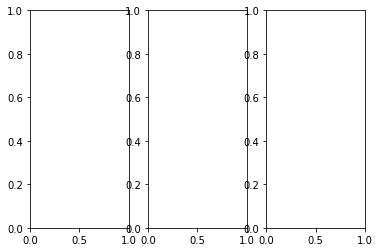

In [35]:
from matplotlib import pyplot as plt
import matplotlib.gridspec

fig, axes = plt.subplots(1, 3)
#fig.suptitle('1 row x 3 columns axes with no data')


In [36]:
# creating axis dictionary
axis_dict = {'Biological process': axes[0],
             'Molecular function': axes[1], 
             'Cellular component': axes[2]}

In [37]:
# creating dictionary for GO2GO-Description

In [38]:
go_enrichment_results.head()

,Ontology,GO slim ID,GO slim name,GO term ID,GO term name,FDR,Species
0,Molecular function,GO:0016829,lyase activity,GO:0004383,guanylate cyclase activity,0.000012,T. saginata
1,Molecular function,GO:0016849,phosphorus-oxygen lyase activity,GO:0004383,guanylate cyclase activity,0.000012,T. saginata
2,Molecular function,GO:0009975,cyclase activity,GO:0004383,guanylate cyclase activity,0.000012,T. saginata
3,Molecular function,GO:0043167,ion binding,GO:0043924,suramin binding,0.000019,T. saginata
4,Molecular function,GO:0033218,amide binding,GO:0043924,suramin binding,0.000019,T. saginata


In [39]:
go_enrichment_results = go_enrichment_results.query("not (Ontology == '-' or `GO term ID` == '-')")

In [40]:
set(go_enrichment_results.query("`GO slim name`.str.contains('transport')").Species.to_list())

{'C. sinensis',
 'E. canadensis',
 'E. granulosus',
 'E. multilocularis',
 'F. hepatica',
 'H. diminuta',
 'H. microstoma',
 'M. corti',
 'M. lignano',
 'O. viverrini',
 'S. curassoni',
 'S. haematobium',
 'S. japonicum',
 'S. mansoni',
 'S. margrebowiei',
 'S. mattheei',
 'S. mediterranea',
 'T. asiatica',
 'T. regenti',
 'T. saginata',
 'T. solium'}

In [41]:
#GO2GOdescript_dict = {row['GO term ID']: row['GO term ID'] + '-' + row['GO term name'] for index,row in go_enrichment_results.iterrows()}

In [42]:
GO2GOdescript_dict = {value.id: value.id+'-'+value.name for value in godag.values()}

In [43]:
go_slims_enriched_toplot.head()

GO slim ID,Ontology,Species,-,GO:0000075,GO:0000077,GO:0000118,GO:0000123,GO:0000149,GO:0000151,GO:0000152,...,GO:2000371,GO:2000377,GO:2000644,GO:2000677,GO:2000736,GO:2000772,GO:2001023,GO:2001057,GO:2001135,GO:2001233
0,Biological process,C. sinensis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biological process,E. canadensis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Biological process,E. granulosus,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Biological process,E. multilocularis,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,Biological process,F. hepatica,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [44]:
go_slims_enriched_toplot.head()

GO slim ID,Ontology,Species,-,GO:0000075,GO:0000077,GO:0000118,GO:0000123,GO:0000149,GO:0000151,GO:0000152,...,GO:2000371,GO:2000377,GO:2000644,GO:2000677,GO:2000736,GO:2000772,GO:2001023,GO:2001057,GO:2001135,GO:2001233
0,Biological process,C. sinensis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Biological process,E. canadensis,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Biological process,E. granulosus,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Biological process,E. multilocularis,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,Biological process,F. hepatica,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc

def plot_clustered_heatmap(df, species_col, godag, min_level, max_level, cmap='viridis', figsize=(10, 30)):
    """
    Plot a clustered heatmap of GO terms vs. species, with GO terms grouped by semantic similarity.
    """
    
    species_order = [
        "H. diminuta", "H. microstoma", "H. nana", "M. corti", 
        "E. granulosus", "E. multilocularis", "E. canadensis", 
        "T. solium", "T. asiatica", "T. saginata", "C. sinensis", 
        "O. viverrini", "F. hepatica", "T. regenti", "S. curassoni", 
        "S. haematobium", "S. japonicum", "S. mansoni", "S. margrebowiei", 
        "S. mattheei", "M. lignano", "S. mediterranea"
    ]
    
    # Filter out GO term columns where all entries are 0 across all species
    go_term_cols = [col for col in df.columns if col.startswith('GO:') and (min_level <= godag.get(col).level <= max_level) and (len(godag.get(col).get_all_upper()) <= max_level)]
    
    # Creating a boolean mask for columns that are not all zeros
    mask = (df[go_term_cols].sum(axis=0) != 0)
    filtered_columns = mask.index[mask].tolist() + [species_col]  # Including the species column
    
    df_filtered = df[filtered_columns].set_index(species_col)
    
    # Transpose DataFrame for plotting (GO terms in rows, species in columns)
    df_plot = df_filtered.transpose()

    # Prepare for semantic similarity calculation
    goids = [go for go in df_plot.index.tolist() if go in godag]
    relationships = {'part_of'}
    relationship2weight = {
        'is_a': 0.5,
        'part_of': 0.5
    }
    
    # Assuming SsWang is correctly implemented and available
    wang_r1 = SsWang(goids, godag, relationships, relationship2weight)
    
    # Calculate the semantic distance matrix
    distances = np.array([[1 - wang_r1.get_sim(goid_a, goid_b) for goid_b in goids] for goid_a in goids])
    
    # Perform hierarchical clustering based on semantic similarity
    linkage = hc.linkage(distances, method='ward')

    # Ensure df_plot is filtered to include only GO terms present in godag (goids)
    df_plot = df_plot.loc[goids]

    # Plotting the heatmap with rows (GO terms) clustered
    g = sns.clustermap(df_plot.rename(GO2GOdescript_dict, axis = 0)[[species for species in species_order if species in df_plot.columns]], row_linkage=linkage, col_cluster=False, cmap=cmap, figsize=figsize, yticklabels=True, linewidths=0.5,linecolor = 'white')
    
    plt.show()
    return (g,df_plot)

## Plotting ontology: Biological process

In [80]:
len(set(go_enrichment_results.Species.to_list()))

21

Missing people here...

In [81]:
# subsetting
go_slims_BP = go_slims_enriched_toplot.query("Ontology == 'Biological process'")
go_slims_BP = go_slims_BP.loc[:, (go_slims_BP.sum(axis=0) != 0) | (go_slims_BP.columns.isin(['Ontology', 'Species']))]

/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/ipykernel_launcher.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


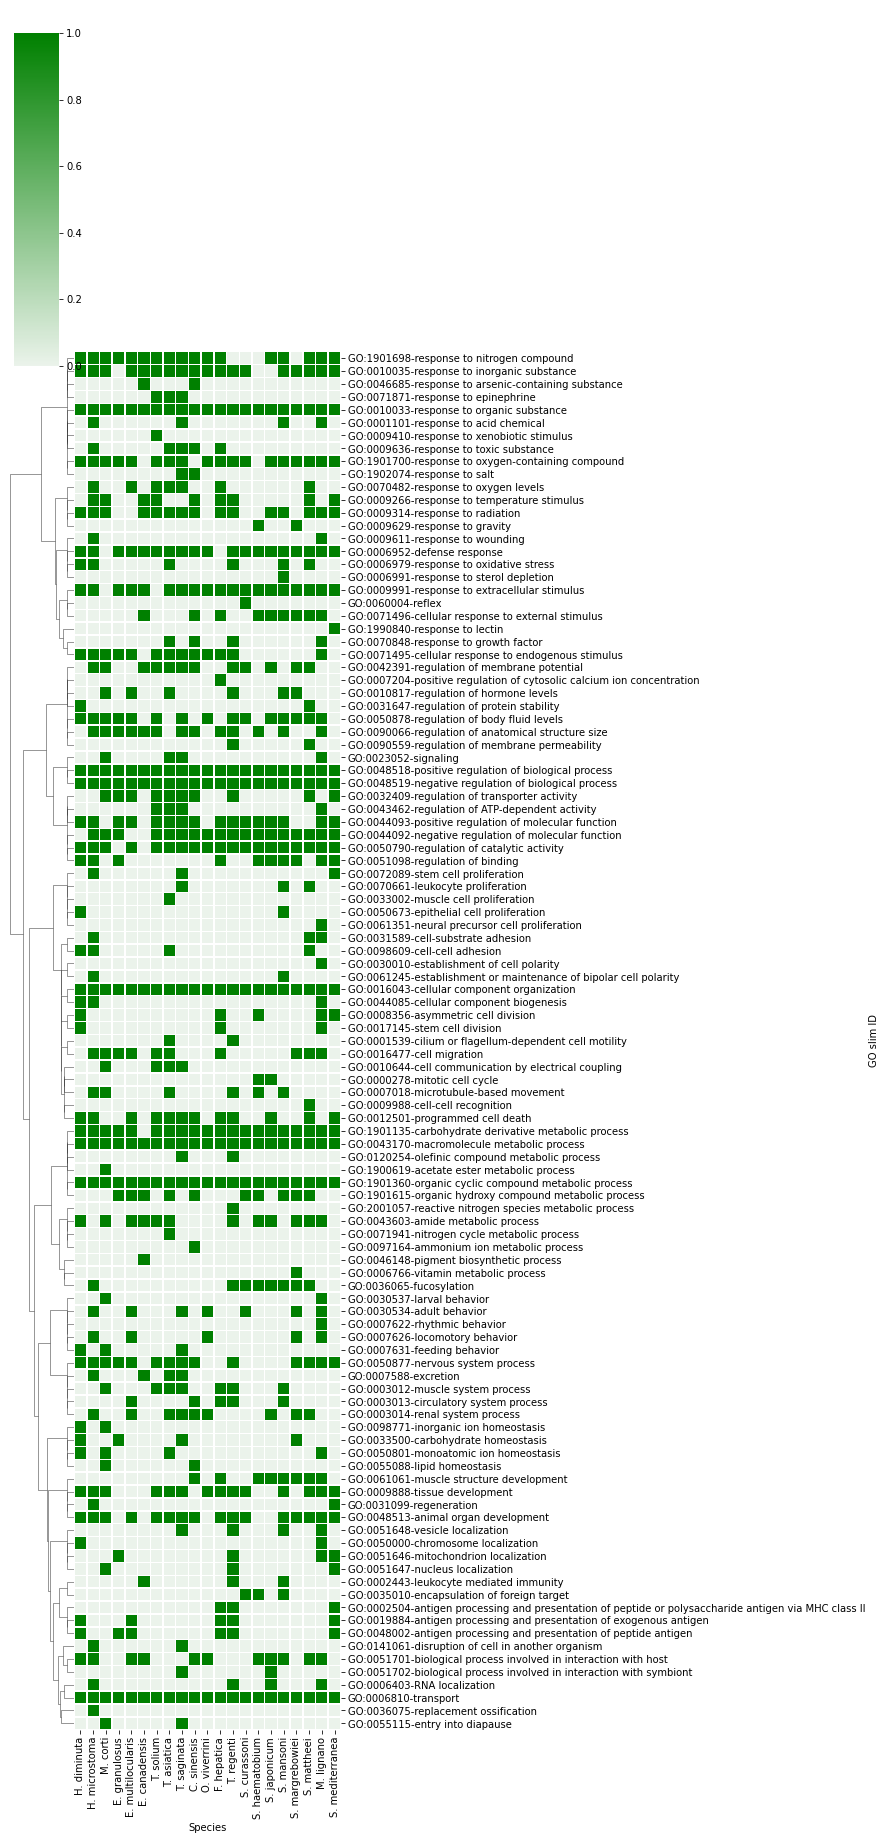

In [112]:
# generating plot
plot_biological_process,biological_process_df = plot_clustered_heatmap(df = go_slims_BP, species_col = 'Species', min_level = 3, max_level = 3, godag = godag, cmap = colorp_dict['Biological process'], figsize = (20/1.45*0.90,65/1.9*0.75))

In [113]:
biological_process_df.reset_index().query("`GO slim ID`.str.contains('GO:0009798')")

Species,GO slim ID,C. sinensis,E. canadensis,E. granulosus,E. multilocularis,F. hepatica,H. diminuta,H. microstoma,M. corti,M. lignano,...,S. haematobium,S. japonicum,S. mansoni,S. margrebowiei,S. mattheei,S. mediterranea,T. asiatica,T. regenti,T. saginata,T. solium


In [114]:
opa = godag.get('GO:0009798')

In [115]:
opa.get_all_upper()

{'GO:0007275',
 'GO:0007389',
 'GO:0008150',
 'GO:0032501',
 'GO:0032502',
 'GO:0048856'}

In [116]:
opa.get_all_parents()

{'GO:0007389', 'GO:0008150', 'GO:0032501'}

In [117]:
# saving plot

In [118]:
plot_biological_process.savefig('../results/figures/go_enrichment_bp.svg')

## Plot ontology: Molecular function

In [119]:
gos_contemplados = [GO_id for GO_id in GO2GOdescript_dict.keys() if godag.get(GO_id).level >= 3 and godag.get(GO_id).level <= 10]

In [120]:
go_enrichment_results.query("FDR > 0.05")

,Ontology,GO slim ID,GO slim name,GO term ID,GO term name,FDR,Species


In [145]:
# subsetting
go_slims_MF = go_slims_enriched_toplot.query("Ontology == 'Molecular function'")
go_slims_MF = go_slims_MF.loc[:, (go_slims_MF.sum(axis=0) != 0) | (go_slims_MF.columns.isin(['Ontology', 'Species']))]

In [146]:
len(set(go_enrichment_results.query("`GO slim name` == 'oxidoreductase activity'").Species.to_list()))

16

/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/ipykernel_launcher.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


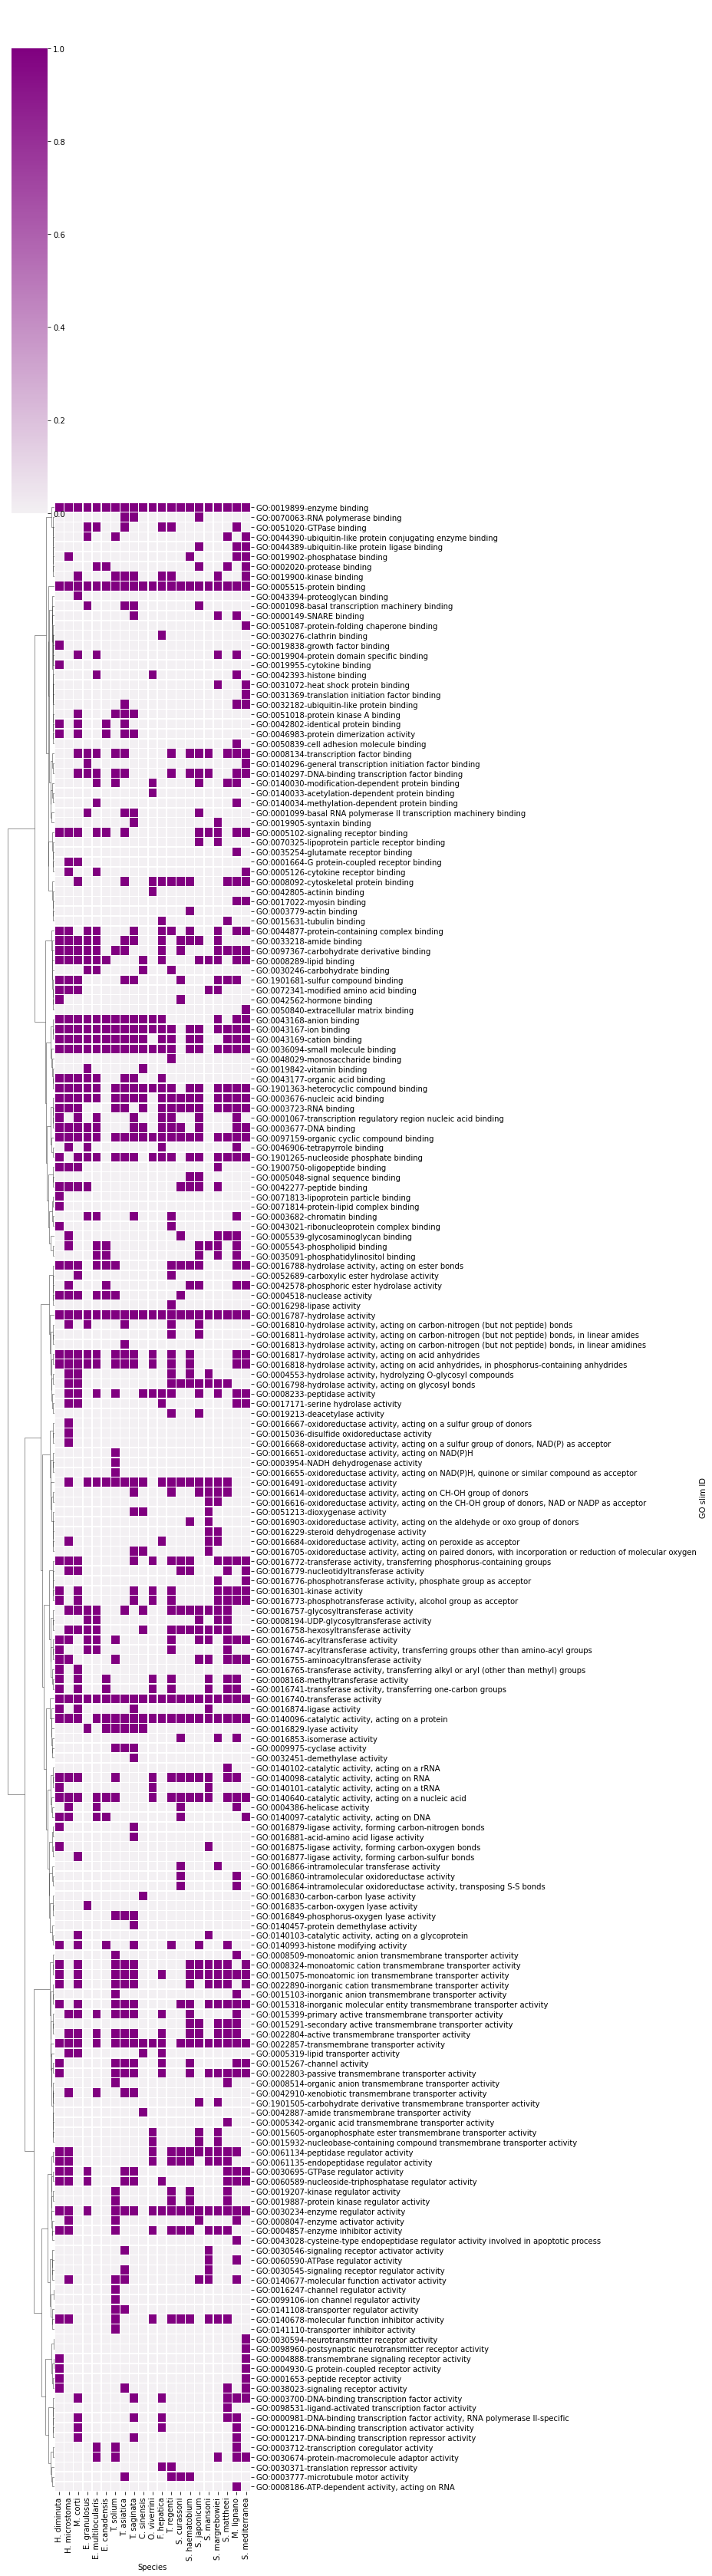

In [147]:
# generating plot
plot_molecular_function,molecular_function_df = plot_clustered_heatmap(df = go_slims_MF, species_col = 'Species', min_level = 2, max_level = 4, godag = godag, cmap = colorp_dict['Molecular function'], figsize = (20*0.65,55*0.85))

In [148]:
# saving plot

In [ ]:
plot_molecular_function.savefig('../results/figures/go_enrichment_mf.svg')

## Plot ontology: Cellular component

In [131]:
# subsetting
go_slims_CC = go_slims_enriched_toplot.query("Ontology == 'Cellular component'")
go_slims_CC = go_slims_CC.loc[:, (go_slims_CC.sum(axis=0) != 0) | (go_slims_CC.columns.isin(['Ontology', 'Species']))]

/home/mauricio/anaconda3/envs/r-environment/lib/python3.6/site-packages/ipykernel_launcher.py:48: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


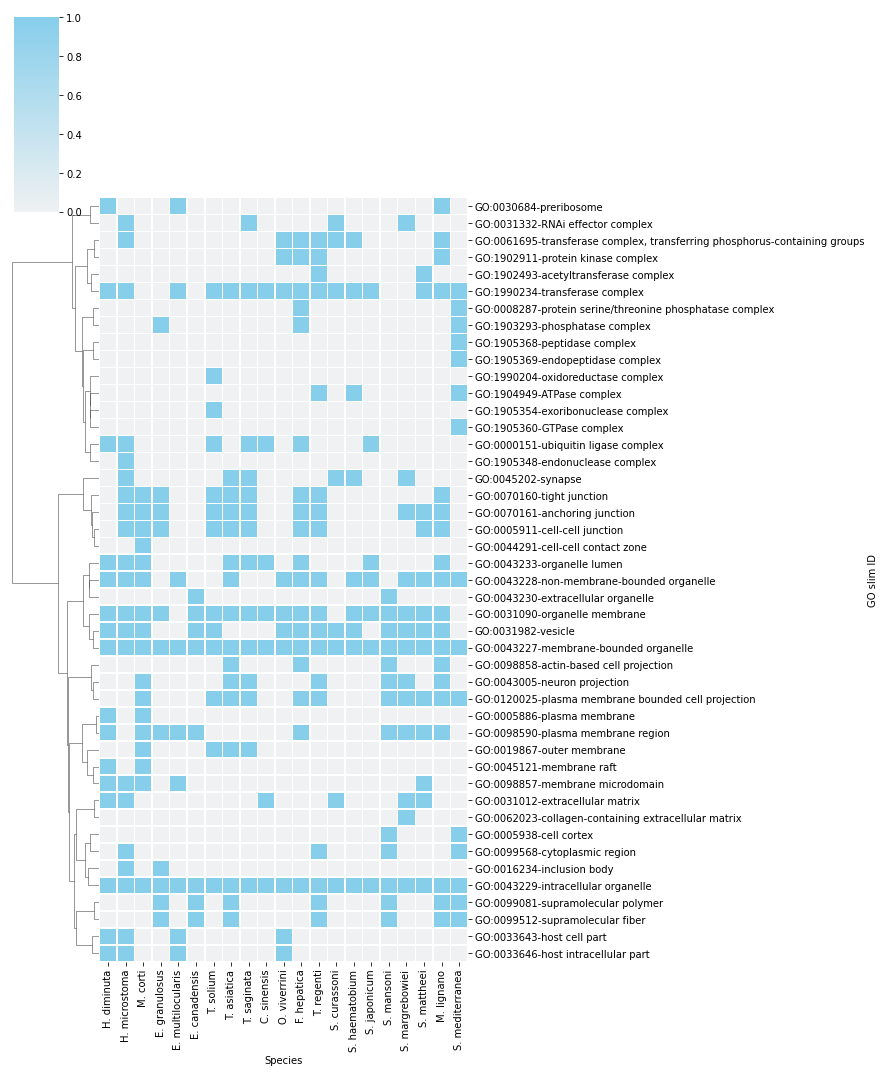

In [137]:
# generating plot
plot_cellular_component,cellular_component_df = plot_clustered_heatmap(df = go_slims_CC, species_col = 'Species', min_level = 3, max_level = 5, godag = godag, cmap = colorp_dict['Cellular component'], figsize = (20*0.62,30*0.5))

In [138]:
# saving plot

In [139]:
plot_cellular_component.savefig('../results/figures/go_enrichment_cc.svg')